# Covariance Matrix Regularization with AutoEncoders

In this project, we will demonstrate how to implement a simple AutoEncoder in TensorFlow and integrate it with Zipline to test the sample covariance matrix regularization via AutoEncoders.




In [1]:
%matplotlib inline
from utils import *



/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/dist-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


### First, let's get some data.

Our sample universe will constitute from the equities of 3 major tech companies, an energy producer, a multinational beverage corporation and ETF's for Gold and 20Y US Treasury Bond.


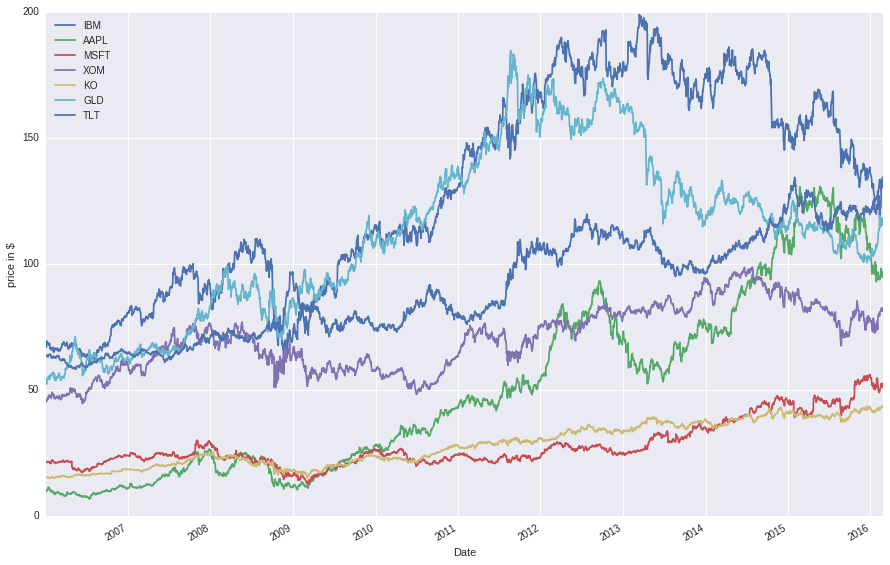

In [3]:
# 7 insts load


universe = ['IBM', 'AAPL', 'MSFT', 'XOM', 'KO', 'GLD', 'TLT']
start = '20060101'
end = '20160228'

data = load_bars_from_yahoo(stocks=universe, start=start, end=end)


'''with open('7Inst.pickle', 'rb') as handle:
    universe, data = pickle.load(handle)
'''    
data.loc[:, :, 'price'].plot(figsize=(15,10))
plt.ylabel('price in $');

### AutoEncoder Graph Builder

Now define a stand-alone TensorFlow graph which will act like an autoencoder. We also defined our loss function in this method.

In [4]:
# A Simple multi-layer Autoencoder definition in TensorFlow
# based on https://github.com/pkmital/tensorflow_tutorials/

def autoencoder(dimensions=[1], denoise_type=0):
    
    # %% input to the network
    x = tf.placeholder(tf.float32, [None, dimensions[0]], name='x')
    current_input = x

    # %% denoising component
    corrupt_prob = tf.placeholder(tf.float32, [1])
    if denoise_type==1:
        current_input = tf.mul(x, tf.cast(tf.random_uniform(shape=tf.shape(x),minval=0,
                    maxval=2, dtype=tf.int32), tf.float32)) * corrupt_prob + x * (1 - corrupt_prob)
    if denoise_type==2:
        current_input = occlude_input(x,corrupt_prob)
        

    # first build the encoder
    encoder = []
    for layer_i, n_output in enumerate(dimensions[1:]):
        n_input = int(current_input.get_shape()[1])
        W = tf.Variable( tf.random_uniform([n_input, n_output], -1.0 / math.sqrt(n_input),
                        1.0 / math.sqrt(n_input)), name="EncWeights-%d" % layer_i)
        b = tf.Variable(tf.zeros([n_output]), name="EncBias-%d" % layer_i)
        encoder.append(W)
        output = tf.nn.tanh(tf.matmul(current_input, W) + b)

        # Set the num of inputs for the next layer
        current_input = output

    # code layer 
    z = current_input
    encoder.reverse()

    # construct the Decoder layers using the same weights
    for layer_i, n_output in enumerate(dimensions[:-1][::-1]):
        W = tf.transpose(encoder[layer_i], name="DecWeights-%d" % layer_i)
        b = tf.Variable(tf.zeros([n_output]), name="DecBias-%d" % layer_i)
        output = tf.nn.tanh(tf.matmul(current_input, W) + b)
        current_input = output

    # this is the reconstruction through the network
    y = current_input
    
    # cost function is the average absolute value of pixel-wise differences
    cost = tf.sqrt(tf.reduce_mean(tf.square(y - x)))
    cost_summ = tf.scalar_summary("cost", cost)

    return {'x': x, 'z': z, 'y': y, 
            'corrupt_prob': corrupt_prob, 'cost': cost, 'cost_summ':cost_summ}



### Training and prediction method


Initiation step:

The following method operates in two separate regimes depending if a tensor-flow-context dictionary is provided;


1. If not it will first use the above method to instantiate an autoencoder, embed it into a TF graph and session. It will also define and attach the optimization op to be used during training.

2. If tensor-flow-context is provided, then it will use that context to further train an existing graph with new data in next step.


Training and estimation step:

Convert covariance matrices provided to correlation and a normalized volatility vector and train the network using those normalized data. Once training is done feed the covmat_target (the last observation of training if None) to the network to receive the regularized vector. Finally, convert this regularized vector of correlations and volatilities back to final covariance estimate. The manipulation of matrices and dividing the sample set into various batches is handled by the following utility class CovarianceDataSet.

In [5]:

def DeepShrinkCovmat(covmats_train, tensorflowcontext=None, covmat_target=None, 
                     args_ae={'layer_dims' : [6,4], 'learn_rate':0.001, 'epochs':1, 'denoise_type':1, 
                              'batch_size':10, 'shuffle_batches':True, 'usevola':False} ):
    
    # Initializations
    trdataset = CovarianceDataSet(covmats_train, shuffle=args_ae['shuffle_batches'])
    
    if covmat_target is None:
        covmat_target = covmats_train[-1]   # If no covmat-to-shrink provided shrink the last observation 
    
    N = covmat_target.shape[0]
    nItems = N * (N-1) / 2 + N

    if tensorflowcontext is None:
        dims = [nItems]
        dims.extend(args_ae['layer_dims'])
        ae = autoencoder(dimensions=dims, denoise_type=args_ae['denoise_type'])
        
        optimizer = tf.train.AdamOptimizer(args_ae['learn_rate']).minimize(ae['cost'])
        
        # We create a TensorFlow session to use the graph
        sess = tf.Session()
        
        # Define summary merger and log-writer for TensorBoard
        merged = tf.merge_all_summaries()
        writer = tf.train.SummaryWriter("./tb_logs", sess.graph_def)
                                       
        # Initialize all TF variables
        sess.run(tf.initialize_all_variables())
    else:
        sess = tensorflowcontext["sess"]
        ae = tensorflowcontext["ae"]
        optimizer = tensorflowcontext["optimizer"]
        merged = tensorflowcontext["merged"]
        writer = tensorflowcontext["writer"]
        
    
    vola_target = np.sqrt(np.diag(covmat_target))
            
    # Iterate through training set via mini-batches
    last_cost = None
    corr_prob = 0.0
    if args_ae['denoise_type']<>0:
        corr_prob = 1.0
    
    # This is where learning happens by iterating through the samples and running the optimizer
    for step in xrange(0, args_ae['epochs'] * trdataset.num_examples, args_ae['batch_size']):
            sess.run( optimizer, feed_dict={ae['x']: trdataset.next_batch(args_ae['batch_size']), 
                                           ae['corrupt_prob']:[corr_prob]} )
    
    target_norm = trdataset.get_normal_form(covmat_target)
    
    recons = sess.run( [ae['y'],ae['cost_summ']], feed_dict={ae['x']: target_norm, ae['corrupt_prob']:[0.0]} )
    recon = recons[0][0]
    cost_summ = recons[1]
    writer.add_summary(cost_summ)
    
    cov_recon = np.diag(np.diag(covmat_target))
    
    try:     
        recon_vola = None
        if not args_ae['usevola']:
            recon_vola = vola_target 
        
        cov_recon = trdataset.reconstruct_covariance(recon,recon_vola)
        
    except ValueError as e:
        print 'Warning: ' + str(e)
        np.copyto(covmat_target, cov_recon)


    return cov_recon


In [6]:
class CovarianceDataSet(object):
            
    def __init__(self, cov_samples, shuffle=True):
        assert len(cov_samples) > 1
        assert len(cov_samples[0].shape) == 2
        assert cov_samples[0].shape[0] == cov_samples[0].shape[1]

        self._num_examples = len(cov_samples)
        self._shuffle = shuffle

        # Convert shape from [num examples, N, N]
        # to [num examples, N*(N-1)/2 + N] which stands for 
        # normalized upper triangular elements
        self._N = cov_samples[0].shape[0]
        nItems = self._N * (self._N-1) / 2 + self._N

        self._volas_array = np.asarray([np.sqrt(diag(cmat)) for cmat in cov_samples])
        self._volas_range = np.asarray([(np.min(self._volas_array[:,n_i]), 
                                         np.max(self._volas_array[:,n_i])) 
                                            for n_i in range(self._N)])

        self._volas_norm = np.asarray([ self.scalemin11(self._volas_array[:,n_i]) 
                                            for n_i in range(self._N) ])

        self._trainingdata = np.asarray([ np.append(cov2corr(cmat)[np.triu_indices(self._N,k=1)], 
                                          self._volas_norm[:,idx]) 
                                        for idx, cmat in enumerate(cov_samples) ])  
        
        self._trainingdata[self._trainingdata < -1.0 + 1.0e-9] = -1.0 + 1.0e-9
        self._trainingdata[self._trainingdata > 1.0 - 1.0e-9] = 1.0 - 1.0e-9
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def training_data(self):
        return self._trainingdata

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def scalemin11(self, vec):       # Scale the vec to [-1, 1]
        if vec.min() == vec.max(): return vec       # to avoid division by zero
        return( 2 * (vec-vec.min()) / float(vec.max()-vec.min()) - 1 )

    def scalemin11back(self, vec, rangev):
        if rangev[0] == rangev[1]: return vec
        return( (vec+1)/2 * float(rangev[1]-rangev[0]) + rangev[0] )

    
    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            if self._shuffle:
                # Shuffle the data
                perm = np.arange(self._num_examples)
                np.random.shuffle(perm)
                self._trainingdata = self._trainingdata[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._trainingdata[start:end]

    def get_normal_form(self, target_mat):
        vola_target = np.sqrt(np.diag(target_mat))
        return np.asarray([np.append(cov2corr(target_mat)[np.triu_indices(self._N,k=1)], 
                np.asarray([ (vola_target[idx] - self._volas_range[idx][0])/
                            (self._volas_range[idx][1]- self._volas_range[idx][0]) 
                            for idx in xrange(self._N) ]))])

    
    def reconstruct_covariance(self, recon, use_vola=None):
        recon_corr = np.eye(self._N)   
        recon_vola = np.asarray([ self.scalemin11back(recon[-self._N:][idx], rangev) 
                                 for idx, rangev in enumerate(self._volas_range) ])

        tri_inds_u = np.triu_indices(self._N,k=1)
        tri_inds_l = tri_inds_u[1], tri_inds_u[0]
        recon_corr[tri_inds_u] = recon[:-self._N]
        recon_corr[tri_inds_l] = recon[:-self._N]

        # Ensure that the regularized correlation matrix will be positive semidefinite
        recon_corr = nearcorr(recon_corr)
        if use_vola is not None:
            recon_vola = use_vola
            
        # Finally, reconstruct covariance matrix from correlations using the volatility estimates
        return corr2cov(recon_corr, recon_vola)


Let's check the method we just defined with some real data!


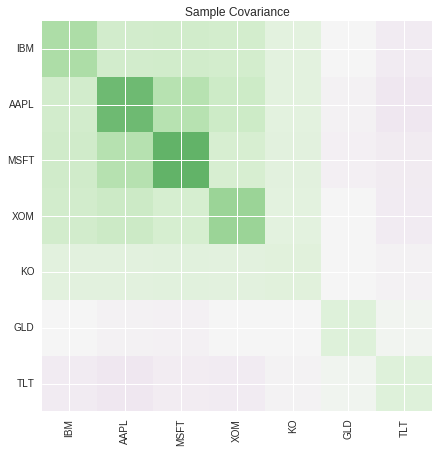

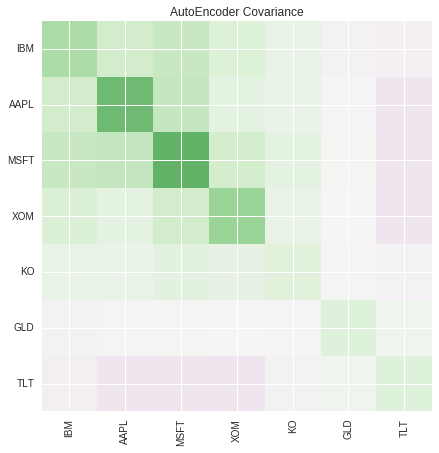

In [7]:
dat = data[:,-700:,'price']
returns = dat.pct_change().dropna()
datalen = len(returns)
covlen = 250

training_covs = [ np.asarray(returns[i:i+covlen].cov()) for i in range(datalen-covlen+1) ]
cov_target = training_covs[-1]


sim_args = { 'layer_dims':[64,32,4], 'learn_rate':0.001, 'epochs':2, 'denoise_type':1, 
             'batch_size':10, 'shuffle_batches':True, 'usevola':False } 

cov_recon = DeepShrinkCovmat(training_covs, args_ae = sim_args )

ShowCovarianceMatrix(cov_target, universe, title='Sample Covariance')
ShowCovarianceMatrix(cov_recon, universe, title='AutoEncoder Covariance')



plt.show()


### Backtest Method with Tensorflow and Zipline integration

In [8]:
def RunBacktest(datatorun, rebalfreq=20, covlen=250, trainlen=100, corrupted_inp=.0, dump_covs = False,
                use_autoencoder=False, args_ae={ 'layer_dims':[1], 'learn_rate':0.1, 'epochs':1, 'denoise_type':0, 
                                                'batch_size':10, 'shuffle_batches':False, 'usevola':False } ):
        
    with tf.Graph().as_default() as g:
        with tqdm.tqdm(total=len(datatorun)) as pbar:
            # We create a TensorFlow session to use the graph
            sess = tf.Session()

            stocks_universe = datatorun.items
            N = len(stocks_universe)
            #cov_diffs = []


            def initialize(context):
                # Set-up system parameters
                context.rebalance_every_nthbar = rebalfreq
                context.covlen = covlen
                context.trainlen = trainlen
                context.datalen = max(context.rebalance_every_nthbar,context.trainlen) + context.covlen
                context.layerdims = args_ae['layer_dims']

                # Register history container to keep a window of past prices.
                add_history(context.datalen, '1d', 'price')
                # Turn off the slippage model and set some realistic commissions for backtester
                set_slippage(slippage.FixedSlippage(spread=0.0))
                set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0))
                context.tick = 0

                # Create AutoEncoder graph
                dims = [N*(N-1)/2+N]
                dims.extend(context.layerdims)
                ae = autoencoder(dimensions=dims)
                optimizer = tf.train.AdamOptimizer(args_ae['learn_rate']).minimize(ae['cost'])

                # Define and log-writer for TensorBoard
                writer = tf.train.SummaryWriter("./tb_logs/logs", sess.graph_def)
                merged = tf.merge_all_summaries()
                # Initialize all TF variables
                sess.run(tf.initialize_all_variables())

                # Finalizing helps us to make sure that we don't add to the graph later by accident
                g.finalize()
                tensorflowcontext = {'sess':sess,'ae':ae, 'optimizer':optimizer, 'writer':writer, 'merged':merged}
                context.tfcontext = tensorflowcontext



            def handle_data(context, data):
                # Allow history to accumulate enough prices before trading
                # and rebalance every n-day thereafter.
                context.tick += 1
                if context.tick < context.datalen:
                    return

                if context.tick % context.rebalance_every_nthbar == 0:   # rebalance every nth bar
                    pbar.update(context.tick)
                    #print '.',     

                    # Get rolling window of past prices and compute returns
                    prices = history(context.datalen, '1d', 'price').dropna()
                    returns = prices.pct_change().dropna()
                    datalen = len(returns)        
                    samplecovs = [ np.asarray(returns[i:i+context.covlen].cov()) 
                                  for i in range (datalen-context.covlen+1) ]

                    covsample = samplecovs[-1]
                    
                    assert corrupted_inp>=0 and corrupted_inp<=1
                    for i in xrange(5):
                        if(np.random.random() < corrupted_inp):        
                            corr, vola = cov2corrvola(covsample)
                            # corrupt a single correlation relationship randomly 
                            corrcrpt = np.copy(corr)                        
                            idx1 = np.random.randint(N)
                            idx2 = idx1
                            while idx1==idx2:
                                idx2 = np.random.randint(N)
                            corrcrpt[idx1,idx2] = np.min([1.0,np.max([-1,-3 * corrcrpt[idx1,idx2]])])
                            corrcrpt[idx2,idx1] = corrcrpt[idx1,idx2]
                            covsample = corr2cov(nearcorr(corrcrpt),vola)


                    covmats2dump = []
                    weights2dump = []


                    try:
                        # Min-Variance portfolio optimization
                        weights = optimal_portfolio_cvxopt(covsample) 
                        if dump_covs:
                            covmats2dump.append(covsample)            
                            weights2dump.append(weights)

                        if use_autoencoder:
                            covshrunk = np.copy(covsample)
                            if( len(samplecovs)>=args_ae['batch_size'] ):
                                covshrunk = DeepShrinkCovmat(samplecovs, tensorflowcontext=context.tfcontext, 
                                                             covmat_target=covsample,  args_ae=args_ae)
                            weights_sh = optimal_portfolio_cvxopt(covshrunk)
                            weights = weights_sh
                            #cov_diffs.append(np.sqrt(np.mean(np.square(y-x))))
                            if dump_covs:
                                covmats2dump.append(covshrunk)          
                                weights2dump.append(weights)
                                ShowCovarsWeights(covmats2dump, weights2dump, stocks_universe, 
                                        './img/covwei_' + get_datetime().strftime("%Y%m%d") + ".png")


                        # Rebalance portfolio accordingly
                        for stock, weight in zip(prices.columns, weights):
                            order_target_percent(stock, weight)
                    except ValueError as e:
                        print 'exception in optim or shrinkage: ' + str(e)


        # Instantinate algorithm        
        algo = TradingAlgorithm(initialize=initialize, handle_data=handle_data)
        
        # Run algorithm
        start_time = time.time()
        results = algo.run(datatorun)
        runtime = time.time() - start_time
        print("\nRuntime: {:.1f} sec, Sharpe: {:.2f}".format(runtime,
                                                            results.sharpe[-1]))
        return results#, cov_diffs
        

### How does the backtests look like?

Let's run the backtest with and without autoencoder shrinkage and compare the results.


Runtime: 20.5 sec, Sharpe: 1.34


160740it [00:17, 19283.83it/s]


Runtime: 22.2 sec, Sharpe: 1.47


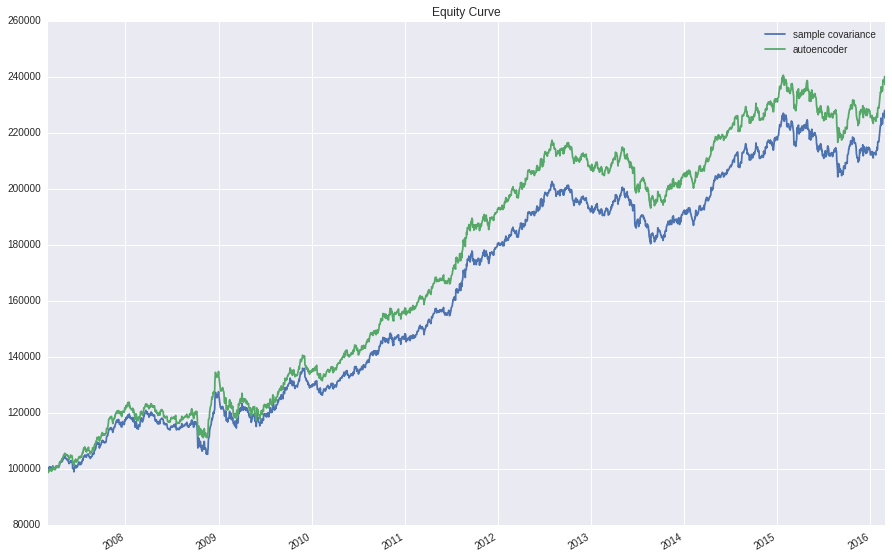

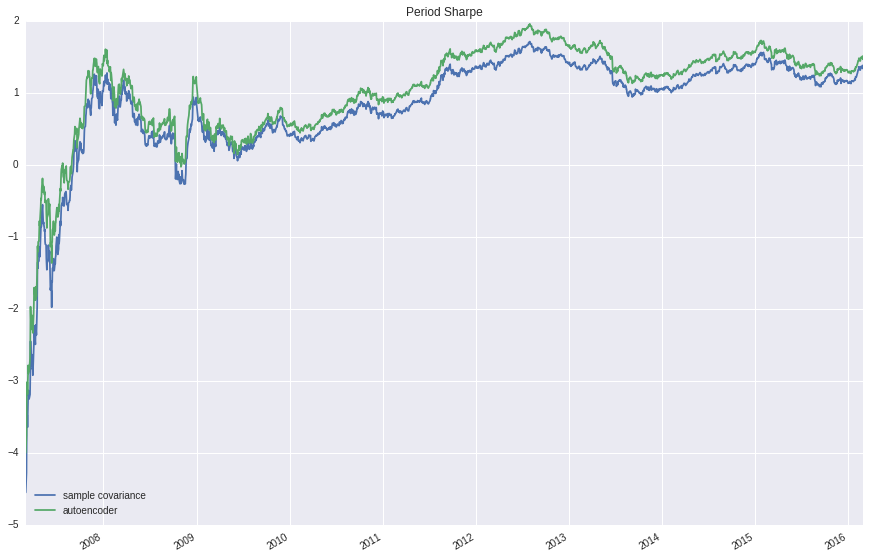

In [9]:
rebal_freq = 20
cov_len = 250
train_len = 20
offset = 2*max(train_len,rebal_freq)+cov_len+1

sim_args = { 'layer_dims':[48,24,4], 'learn_rate':0.001, 'epochs':1, 'denoise_type':1, 
             'batch_size':10, 'shuffle_batches':True, 'usevola':False } 

res1 = RunBacktest(data, rebalfreq=rebal_freq, covlen=cov_len, trainlen = train_len,
                          use_autoencoder=False)

res2 = RunBacktest(data, rebalfreq=rebal_freq, covlen=cov_len, trainlen = train_len,
                         use_autoencoder=True, args_ae = sim_args)              


plt.figure(figsize=(15,10))
res1.ending_value[offset:].plot(label='sample covariance',legend=True)
res2.ending_value[offset:].plot(label='autoencoder',legend=True, title='Equity Curve');

plt.figure(figsize=(15,10))
res1.sharpe[offset:].plot(label='sample covariance',legend=True)
res2.sharpe[offset:].plot(label='autoencoder',legend=True, title='Period Sharpe');


Results looks reasonable and regularization method seem to be contributing in the above example. Obviously, we need to run many more simulations in order to make any conclusion. The example above is for demonstration purposes only and the real power of such an approach will be arguably only demonstrable with bigger universes and a lot more data (i.e. higher frequencies).

### Another use case for AutoEncoder Regularization: Anomaly Detection
Assume we have an upcoming datastream and we are estimating our covariance matrix and changing underlying portfolio accordingly in a continous fashion throughtout the day. What happens if we receive a bad data point? Autoencoders are useful fixing out those problematic cases. Below we will deliberately corrupt one point in our covariance matrix and show that by simply filtering it throughout the AutoEncoder network we will get the cleaned up version.


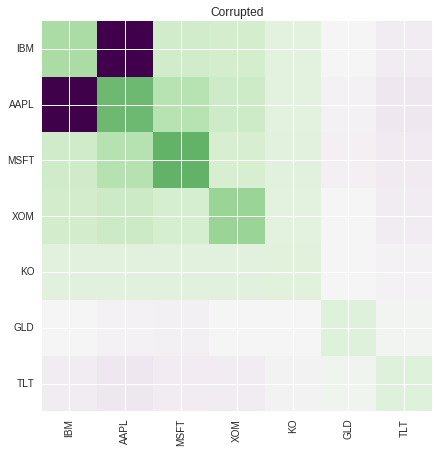

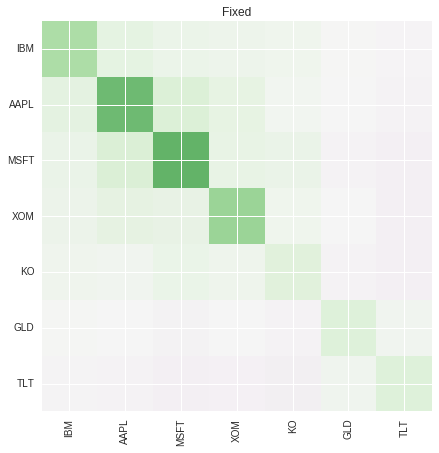

In [10]:
dat = data[:,-700:,'price']
returns = dat.pct_change().dropna()
datalen = len(returns)
covlen = 250

training_covs = [ np.asarray(returns[i:i+covlen].cov()) for i in range(datalen-covlen+1) ]
cov_target = training_covs[-1]


sim_args = { 'layer_dims':[64,32,4], 'learn_rate':0.001, 'epochs':2, 'denoise_type':1, 
             'batch_size':10, 'shuffle_batches':True, 'usevola':False } 


cov_target_corrupted = np.copy(cov_target)
cov_target_corrupted[0,1] = cov_target_corrupted[1,0] = -10 * cov_target_corrupted[0,1]

ShowCovarianceMatrix(cov_target_corrupted, universe, title='Corrupted')

cov_target_fixed = DeepShrinkCovmat(training_covs, covmat_target=cov_target_corrupted, 
                                    args_ae = sim_args )

ShowCovarianceMatrix(cov_target_fixed, universe, title='Fixed')

Finally, we can also try a similar approach in a simulation setting where we corrupt the covariance matrix with some probability at every observation and track how such an environment would effect our backtest. By using such a regularization technique, we not only have a more robust and stable system, by simply tracking the cost value of the AutoEncoder we will have a Anomaly detection capabilities. Anytime the cost is too high, that tells us something suspicious is happening (either bad data or significant market change) which may require some closer attention. We don't care about the performance below that much, it can be pretty much random. In TensorBoard, we can see how the average cost higher than previous case is.


Runtime: 20.9 sec, Sharpe: 0.96


160740it [00:17, 19265.62it/s]


Runtime: 21.8 sec, Sharpe: 1.42


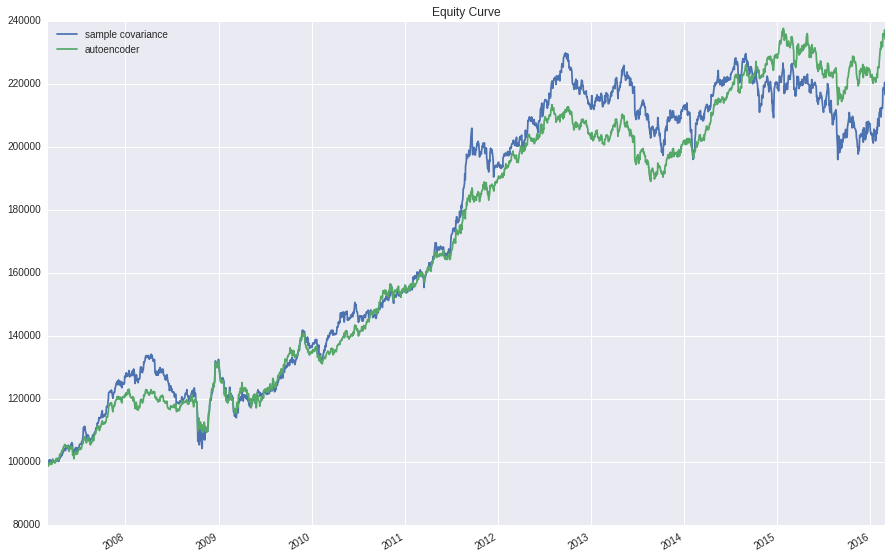

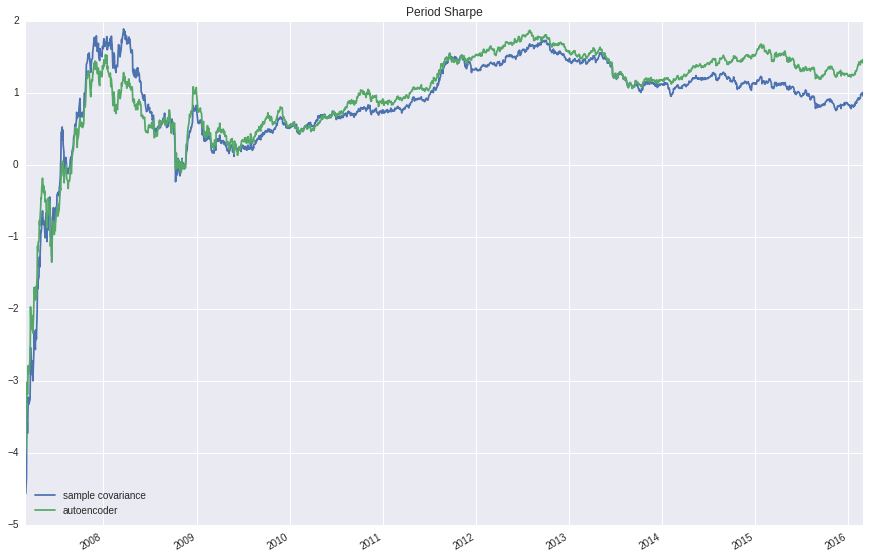

In [12]:
rebal_freq = 20
cov_len = 250
train_len = 20
offset = 2*max(train_len,rebal_freq)+cov_len+1

sim_args = { 'layer_dims':[48,24,4], 'learn_rate':0.001, 'epochs':1, 'denoise_type':1, 
             'batch_size':10, 'shuffle_batches':True, 'usevola':False } 


res1 = RunBacktest(data, rebalfreq=rebal_freq, covlen=cov_len, trainlen = train_len,
                          use_autoencoder=False,corrupted_inp=0.7)

res2 = RunBacktest(data, rebalfreq=rebal_freq, covlen=cov_len, trainlen = train_len,
                         use_autoencoder=True, args_ae = sim_args, corrupted_inp=0.7)              


plt.figure(figsize=(15,10))
res1.ending_value[offset:].plot(label='sample covariance',legend=True)
res2.ending_value[offset:].plot(label='autoencoder',legend=True, title='Equity Curve');

plt.figure(figsize=(15,10))
res1.sharpe[offset:].plot(label='sample covariance',legend=True)
res2.sharpe[offset:].plot(label='autoencoder',legend=True, title='Period Sharpe');


Prepared for QuantCon 2016 
@ Erk Subasi, 2016, Limmat Capital Alternative Investments AG

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.